In [1]:
import xarray as xr
import numpy as np
import glob
import cftime
import os
import matplotlib.pyplot as plt
import cartopy
from scipy import interpolate
import math

thickness_file="/work/Feiyu.Lu/ECDA_data/vgrid_75_2m.nc"
thickness_ds=xr.open_dataset(thickness_file)
thickness=thickness_ds.dz
sec_per_julian_year=3600*24*365.25
sec_per_day=3600*24

year=2010
month=1
argo_ds=xr.open_dataset('/work/Feiyu.Lu/ECDA_data/argo_old/argo_{}.nc'.format(year))
time_start=np.datetime64('{}-{:02d}-01'.format(year,month))
time_end=np.datetime64('{}-{:02d}-10'.format(year,month)) if month<12 else np.datetime64('{}-01-01'.format(year+1))

argo_times_all=argo_ds.time
argo_lats_all=argo_ds.latitude
argo_lons_all=argo_ds.longitude
argo_links_all=argo_ds.link

# argo_times=np.array(argo_times_all[(argo_ds.station_index<1000) & (argo_links_all==0)])
# argo_lats=np.array(argo_lats_all[(argo_ds.station_index<1000) & (argo_links_all==0)])
# argo_lons=np.array(argo_lons_all[(argo_ds.station_index<1000) & (argo_links_all==0)])

argo_times=np.array(argo_times_all[(argo_times_all>time_start) & (argo_times_all<time_end) & (argo_links_all==0)])
argo_lats=np.array(argo_lats_all[(argo_times_all>time_start) & (argo_times_all<time_end) & (argo_links_all==0)])
argo_lons=np.array(argo_lons_all[(argo_times_all>time_start) & (argo_times_all<time_end) & (argo_links_all==0)])
print(argo_lats.shape)

# fig1, axes1=plt.subplots(nrows=1, ncols=1, figsize=(12,8), subplot_kw={'projection': cartopy.crs.PlateCarree()})
# axes1.scatter(argo_lons,argo_lats,transform=cartopy.crs.PlateCarree(),s=1,c='blue')
# axes1.coastlines()
# axes1.add_feature(cartopy.feature.LAND)

da_dir='/archive/fnl/SPEAR/SPEAR_c96_o1_ECDA_M10'
temp_inc_ds=xr.open_dataset(da_dir+'/pp_ensemble/ocean_z_daily/ts/daily/1yr/ocean_z_daily.20100101-20101231.temp_increment.nc')
# salt_inc_ds=xr.open_dataset(da_dir+'/pp_ensemble/ocean_z_daily/ts/daily/1yr/ocean_z_daily.20100101-20101231.salt_increment.nc')
temp_bg_ds=xr.open_dataset(da_dir+'/pp_ensemble/ocean_z_daily/ts/daily/1yr/ocean_z_daily.20100101-20101231.thetao.nc')
# salt_bg_ds=xr.open_dataset(da_dir+'/pp_ensemble/ocean_z_daily/ts/daily/1yr/ocean_z_daily.20100101-20101231.so.nc')

temp_inc=temp_inc_ds['temp_increment']
# salt_inc=salt_inc_ds['salt_increment']
temp_bg=temp_bg_ds['thetao']
# salt_bg=salt_bg_ds['so']
levels=len(temp_inc.z_l)

for da in [temp_inc,temp_bg]:
    datetimeindex = da.indexes['time'].to_datetimeindex()
    da['time']=datetimeindex
    
temp_inc_array=np.zeros((levels,len(argo_times)))
temp_bg_array=np.zeros((levels,len(argo_times)))
    
for i,sample_time in enumerate(argo_times):
    sample_lat=argo_lats[i]
    sample_lon=argo_lons[i]
    sample_period=slice(sample_time-np.timedelta64(1,'D'),sample_time+np.timedelta64(1,'D'))
    
    temp_inc_sample=temp_inc.sel(xh=sample_lon,yh=sample_lat,method='nearest').sel(time=sample_period).mean('time')
    temp_inc_sample=np.where(np.isnan(temp_inc_sample),0.0,temp_inc_sample)*sec_per_day*thickness.data
    temp_bg_sample=temp_bg.sel(xh=sample_lon,yh=sample_lat,method='nearest').sel(time=sample_period).mean('time')
    temp_bg_sample=np.where(np.isnan(temp_bg_sample),0.0,temp_bg_sample)
    
    temp_inc_array[:,i]=temp_inc_sample
    temp_bg_array[:,i]=temp_bg_sample

(2185,)


/vftmp/Feiyu.Lu/pid20460/ipykernel_21784/2352876491.py:55: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()


In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
import torch.nn.functional as F

from sklearn.metrics import r2_score
np.random.seed(14) # For reproducibility 
torch.manual_seed(14) # For reproducibility

In [3]:
def train_model(net,criterion,trainloader,optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x) # Inputs
        b_y = Variable(batch_y) # outputs
        if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)   # Calculating loss 
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
#         test_loss = test_loss + loss.data.numpy() # Keep track of the loss for convenience 
#     test_loss /= len(trainloader) # dividing by the number of batches
#     print('the loss in this Epoch',test_loss)
#     print(b_y.shape)
#     print(prediction.shape)

def test_model(net,criterion,trainloader,optimizer, text = 'validation'):
    net.eval() # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
            b_x = Variable(batch_x) # Inputs
            b_y = Variable(batch_y) # outputs
            if len(b_x.shape) == 1: # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(net(torch.unsqueeze(b_x,1)))# input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)   # Calculating loss 
            test_loss = test_loss + loss.data.numpy() # Keep track of the loss 
        test_loss /= len(trainloader) # dividing by the number of batches
#         print(len(trainloader))
        print(text + ' loss:',test_loss)
    return test_loss

In [9]:
input_data=np.vstack((np.cos(argo_lats*np.pi/180),temp_bg_array)).transpose()
output_data=temp_inc_array.transpose()

input_train=input_data[:-100,:]
output_train=output_data[:-100,:]

input_test=input_data[-100:,:]
output_test=output_data[-100:,:]
print(input_test.shape)
print(output_test.shape)

(100, 76)
(100, 75)


In [5]:
torch_dataset = Data.TensorDataset(
    torch.from_numpy(input_train).double(),
    torch.from_numpy(output_train).double()
)

BATCH_SIZE = 1024 # Number of sample in each batch

loader = Data.DataLoader(
        dataset=torch_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(input_test).double(),
    torch.from_numpy(output_test).double()
)

loader_test = Data.DataLoader(
        dataset=torch_dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=True)

In [10]:
import torch.nn.functional as FF

class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(76, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 75)  # 8 outputs
#         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [11]:
torch.manual_seed(14) # For reproducibility 
nn_3l = Net_ANN().double()

train loss: 1.1630084172274004
validation loss: 0.6997702085382381
train loss: 0.5160914615971078
validation loss: 0.3705798528970491
train loss: 0.4320926542366556
validation loss: 0.30719388527867925
train loss: 0.2256470993875679
validation loss: 0.2507422108061807
train loss: 0.28521911924253013
validation loss: 0.2285285333771975
train loss: 0.17179363774125836
validation loss: 0.2274713289226213
train loss: 0.16682247763411526
validation loss: 0.22471907490892512
train loss: 0.16000717560147232
validation loss: 0.2225573298381623
train loss: 0.27635475682695126
validation loss: 0.2208080266421149
train loss: 0.18824047153726506
validation loss: 0.21856158475675008
train loss: 0.23752282678348954
validation loss: 0.216692119324936
train loss: 0.14270621229545896
validation loss: 0.21481569676534595
train loss: 0.16076919319814184
validation loss: 0.21309135376280858
train loss: 0.2708523668802332
validation loss: 0.21133638225276363
train loss: 0.15175282476952356
validation loss:

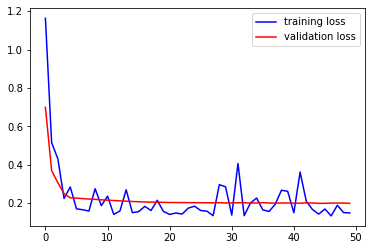

In [12]:
criterion = torch.nn.MSELoss() # MSE loss function
n_epochs = 50 #Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
# time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l,criterion,loader,optimizer)
    train_loss.append(test_model(nn_3l,criterion,loader,optimizer, 'train'))
    validation_loss.append(test_model(nn_3l,criterion,loader_test,optimizer))
plt.plot(train_loss,'b', label='training loss');
plt.plot(validation_loss,'r', label='validation loss');

plt.legend();

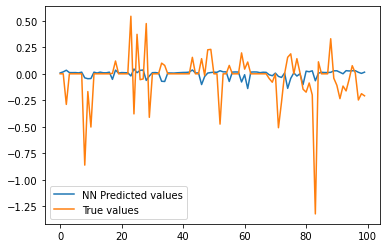

In [13]:
preds22 = nn_3l(torch.from_numpy(input_test[:,:]).double())
plt.plot(preds22.detach().numpy()[0:100,0], label='NN Predicted values')
plt.plot(output_test[:100,0], label='True values');

plt.legend();